# sprint13-dnn-scratch

### DNNとは

DeepNeuralNetwork(DNN)とはニューラルネットワークを文字通りdeepに(深く)したものです。

ニューラルネットワークが３層（入力層、隠れ層、出力層）だったのに対し、DNNは隠れ層が４つ以上のものを指します。

非線形関数の層をより深く組み合わせていくことで認識精度が高まることが経験的に分かっています。

一方で層を深くすることでメリットだけでなく**勾配爆発/消失、過学習**といった問題が発生する恐れもあります。

- 勾配爆発
- 勾配消失

    - バックプロパゲーションで勾配を求める際を考える。計算グラフで乗算ノードとなる層（全結合層、畳み込み層など）が複数層ある場合、勾配の値は基本的に-1から1の間の値を取るため前の層に行くほど小さくなってしまう。つまり前の層ほど学習スピードが遅くなってしまい層が深いネットワークでは勾配がほぼゼロになってしまい更新が行われなくなる問題が**勾配消失**と呼ぶ。
    また逆に勾配が大きくなりすぎてパラメータが発散していくことを**勾配爆発**問題と呼ぶ。

- 過学習
    - 層を深くすることで表現力が増すため、学習データに対する精度はどんどん上がっていきます。これが行き過ぎると学習データに最適化されすぎて未学習のデータに対する精度が下がってしまう。このように特定のデータにだけ性能が高く、汎化性能が落ちることを**過学習**と呼びます。
    
    
DNNを構築する際は上記のような問題に対処できるような工夫（ReLUを使う、正則化項）や機能層（ドロップアウト、バッチノーマリゼーション）を採用する必要があります。

### データのロード

mnistの手書き文字認識問題

784ピクセルの値（0-255）から数字（0-9）を分類する。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas as pd

%matplotlib inline

train_df = pd.read_csv("train.csv", nrows=10000)
# test_df = pd.read_csv("test.csv", nrows=100)

X = train_df.drop('label', axis=1)
y = pd.get_dummies(train_df['label'])
X = np.array(X)
y = np.array(y)


from sklearn.model_selection import train_test_split

# 訓練とテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### 出力関数　ソフトマックス関数

In [3]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

### コスト関数

In [4]:
def cross_entropy_error(y, y_pred):
    
    data_size = y.shape[0]

    # クロスエントロピー誤差関数　y_predは０になりえるので -inf にならないためにすごく小さい補正値を入れる
    cross_entorpy = -np.sum(y * np.log(y_pred + 1e-7))
    
    error = cross_entorpy  / data_size
    return error

### 正答率を算出する関数

In [6]:
# 正答率を算出する
def accuracy_score(X, y, params):
    y_pred =  predict(X, params)
    y_pred_number = np.argmax(y_pred, axis=1)
    
    y_label = np.argmax(y, axis=1)
    
    data_size = X.shape[0]
    
    correct_count = np.sum([y_label == y_pred_number]) 
    score = correct_count / data_size * 100
    
    return round(score, 2)

In [7]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 損失関数
        self.y = None       # softmaxの出力
        self.t = None       # 教師データ（one-hot vector)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size # delta3に相当
        
        return dx

### アフィン変換層


#### Optimizer

今回はパラメータ更新に下記の３つのOptimizerを使って更新を行う。

#### SGD　（Stochastic Gradient Decent：確率的勾配降下法）

Gradient Decentがバッチ処理ですべてのデータを使って更新を行っていました。

データが大きくなったり、リアルタイムでデータが更新されるシステムに適さないこともあります。

SGDは更新に使うデータ量を全データではなく１つからN個（ミニバッチと呼ばれるかたまり）で処理をする手法です。

データの選択（ランダムか順番）やデータ数をいくつにするかはシステムによります。

たとえば外れ値が多いデータはデータ数を１にするとそのデータに引っ張られて適切なパラメータにならないためN個のデータを使ったほうがよいでしょう。

以下に説明するOptimizerはすべてSGDのやり方（処理数を絞る）を引き継いでおり、パラメータの更新式が異なります。


#### AdaGrad

AdaGradはAdaptiveに由来し、下記のような式でパラメータを更新します。

$h = h + \frac{\delta L}{\delta W} \cdot \frac{\delta L}{\delta W}$

$W = W - \eta\frac{1}{\sqrt{h}}  \frac{\delta L}{\delta W}$

学習率をパラメータごと「適応的」に調整することで、勾配が大きいものは更新量は小さく、勾配が小さいものは更新量は大きくすることで



#### Adam

Adamは上述のAdaGradとMomentumを融合したものです。

Momentumはボールが地面を転がるときの空気抵抗や摩擦抵抗で徐々に減速していくようにパラメータを更新していくため、SGDよりジグザグ度合いが軽減されて結果的にすばやく収束することができます。

更新式は下記のようになっており$\alpha$は摩擦係数（速度を減衰させるもの）を表します。

$v = \alpha v -\eta \frac{\delta L}{\delta W}$

$W = W + v$


MomentumとAdaGradを組み合わせることで収束スピードも早く、各パラメータの更新量も細かく調整することができます。


### Optimizerの実装

下記ではAffineレイヤの更新をSGD,AdaGrad,Adamと切り替えられるように実装しています



In [8]:
class Affine:
    def __init__(self, W, b, params= {}):
        self.W = W
        self.b = b
        self.x = None
        # パラメータの微分値
        self.dW = None
        self.db = None
        # 更新式のスイッチング
        self.lr = params['lr']
        
        # optimizeメソッドを
        if params['optimizer']=='sgd':
            self.optimize = self.update_sgd
        elif params['optimizer'] == 'adagrad':
            self.h = np.zeros_like(W)
            self.optimize = self.update_adagrad
        else: # params['optimizer'] == 'adam':
            self.m = np.zeros_like(W)
            self.v = np.zeros_like(W)
            self.beta1 = 0.9
            self.beta2 = 0.999
            self.optimize = self.update_adam
        
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out
    
    def backward(self, dout=1):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        return dx
    
    def update_sgd(self):
        self.W -= self.lr * self.dW
        self.b -= self.lr * self.db
    
    # adagrad 少しずつ更新量が減っていく
    def update_adagrad(self, lr = 0.01):
        self.h += self.dW ** 2
        self.W -= self.lr * self.dW / (np.sqrt(self.h) + 1e-7)
        self.b -= self.lr * self.db
        
    
    def update_adam(self, lr = 0.01):
        self.m = self.beta1 * self.m + (1- self.beta1) * self.dW
        self.v = self.beta2 * self.v + (1- self.beta2) * (self.dW * self.dW)
        
        m_hat = self.m / (1 - self.beta1)
        v_hat = self.v / (1 - self.beta2)
        
        self.W -= self.lr * m_hat / (np.sqrt(v_hat) + 1e-8)
        self.b -= self.lr * self.db
        

### 活性化関数層


In [9]:
class Activation:
    '''
    TODO: 活性化関数 func_nameで切り替えられるにしたい
    しかし毎回IF文で分岐させることになるので一旦はtanhのみにする
    'tanh'
    'sigmoid'
    'relu'
    '''
    def __init__(self):
        #self.out = None
        self.mask = None
     
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

    # tanh 
#     def forward(self, x):
#         out = np.tanh(x)
#         self.out = out
        
#         return out
    
#     def backward(self, dout):
#         dx = dout * (1 - np.tanh(dout)**2)
        
#         return dx
        

### バッチノーマリゼーション層

Batch Normalization層とはフィーチャースケーリングを行うことで

効果として、

- 学習速度を早める
- 初期値にそれほど依存しない
- 過学習を抑制する

In [33]:
class BatchNorm:
    def __init__(self, params):
        self.out = None
        
        self.beta = 0
        self.gamma = 1
        self.lr = params['lr']
        
        self.eps = 1e-8
        ## ここからパクリ
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None
        self.momentum = 0.9
        self.input_shape = None # Conv層の場合は4次元、全結合層の場合は2次元  

        # テスト時に使用する平均と分散
        self.running_mean = None # running_mean
        self.running_var = None # running_var 

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx
    
    def optimize(self):
        self.gamma -= self.lr * self.dgamma
        self.beta -= self.lr * self.dbeta
        

### ドロップアウト層

これまでの層は出力は必ず次の層の入力として使われていました。

ドロップアウト層は確率的に出力をゼロにする、つまりノードを消失させます。

これにより過学習を防ぎ、汎化性能を高めることができる。

更新ごとに消失させるノードを変更できます。




In [23]:
class Dropout:
    
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    
    def forward(self, x, train_flg=True):
        if train_flg :
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1 - self.dropout_ratio)
    
    
    def backward(self, dout):
        return dout * self.mask

In [11]:
unit_size_list = [784]
unit_size_list.extend([100, 100])
unit_size_list.append(10)

In [12]:
unit_size_list

[784, 100, 100, 10]

### 複数層を束ねるクラス(ネットワーククラス)

### 重みの初期化

#### ガウス初期化

標準偏差１のガウス分布で初期化してしまうと各層での出力が1や０付近に分布することになり、
勾配消失・爆発の問題が発生しやすくなってしまいます。

この問題を防ぐために平均０、標準偏差0.01のガウス分布で初期化したものがガウスの初期化です。

ガウス分布での初期化はシンプルですが、もとの値が０．５付近に集中するため

層を深くしても、同じような出力を出すため表現力という面で問題があります。

#### Xavier

前層のノード数がnのとき${\sqrt{\frac {1}{n}}}$を標準偏差とするガウス分布に基づいて初期化するものです。

この初期化でガウス初期化よりは広がりをもった分布になるため表現力を確保できているといえます。

#### He

前層のノード数がnのとき${\sqrt{\frac {2}{n}}}$を標準偏差とするガウス分布に基づいて初期化するものです。

Xavierと比較すると分子が２倍になっているだけで何が変わるのでしょうか？

活性化関数がReLu関数を採用した場合、シグモイド関数やtanh関数は負の値にも分布しているのに対し、ReLu関数は正の値しか返しません。

このためシグモイド関数やtanh関数と同じ広がりを持たせるために分布を２倍させているのです。

一般的に活性化関数がシグモイド関数やtanh関数の場合はXavier、ReLu関数の場合はHeを使うのがベストプラクティスとして知られています。


### 実装

実装は下記コードの１5−２3行目にあります。


In [38]:
from collections import OrderedDict

class Layers:
    def __init__(self, input_size, hidden_layer_list, output_size, params):
        unit_size_list = [input_size]
        unit_size_list.extend(hidden_layer_list)
        unit_size_list.append(output_size)
        
        self.params = {}
        
        # レイヤの生成
        self.layers = OrderedDict()
        
        for i in range(1, len(unit_size_list)):
            # 重みの初期化
            init_W = np.random.randn(unit_size_list[i-1], unit_size_list[i])
            init_b = np.zeros([1, unit_size_list[i]])
            if params['init'] == 'gauss':
                init_W *= 0.01
            elif params['init'] == 'xavier':
                init_W /= np.sqrt(unit_size_list[i-1])
            else: # He
                init_W = init_W / np.sqrt(unit_size_list[i-1]) * np.sqrt(2) 
                
            # アフィン変換層（Wx + b）を追加する
            self.layers['Affine' + str(i)] = Affine(init_W, init_b, params)
            
            # 最終層以外はバッチノーマリゼーション層と活性化関数層を追加する
            if i < (len(unit_size_list)-1):
                if params['batch_norm'] == True:
                    self.layers['BatchNorm' + str(i)] = BatchNorm(params)
                self.layers['Active' + str(i)] = Activation()
                if params['dropout_ratio'] > .0:
                    print(params['dropout_ratio'])
                    self.layers['Dropout' + str(i)] = Dropout(dropout_ratio=params['dropout_ratio'])
        
        self.lastLayer = SoftmaxWithLoss()
        
        self.params['hidden_layer_num'] = len(unit_size_list)-1
        
    def predict(self, x, train_flg=True):
        # forwardを繰り返す
        # ソフトマックスを通さなくても答えは出るのでこれで予測とする 
        # argmaxでラベルを取れる
        for layer in self.layers.values():
            x =layer.forward(x)

        return x
    
    # 予測の際はこちらを使う
    def predict_after_trained(self, x):
        for layer in self.layers.values():
            if layer.__class__.__name__ in ['Dropout', 'BatchNorm']:
                x =layer.forward(x, train_flg=False)
            else:
                x =layer.forward(x)

        return x

    def accuracy(self, x, t):
        # 正答率を小数点第二桁で出力する
        y_pred = self.predict_after_trained(x)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(t, axis=1)
        data_size = x.shape[0]

        correct_count = np.sum([y_true == y_pred]) 
        score = correct_count / data_size * 100

        return round(score, 2)
    
    def loss(self, x, t):
        y = self.predict(x)
        
        return self.lastLayer.forward(y, t)
    
    
    def optimize(self, x, t):
        
        # forward 
        self.loss(x, t)
        
        # backward
        dout = self.lastLayer.backward(1)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        # optimizeメソッドがある層は更新を行う
        # AffineとBatchNorm層のみ行うはず
        for layer in self.layers.values():
            if hasattr(layer, "optimize"):
                layer.optimize()
            

In [81]:
from sklearn.model_selection import train_test_split


class DNN:
    def __init__(self, init='gauss', iteration = 500, lr = 0.05,  lam = 0.01, 
                 batch_mode = 'mini',
                 batch_size_rate = 0.1, hidden_layer_list = [5], optimizer='sgd',
                 batch_norm=False, dropout_ratio=0.0):
        """ ハイパーパラメータ解説
        init: 初期化方法
            'he' : 
            'gauss' 
            'xavier'
        lr : 学習率
        lam : 正則化項の率
        batch_size: バッチサイズ
            'batch' : フルサイズ
            'mini' 0< x< 1: フルサイズ割合 0.1なら全体の0.1サイズ使用する
            'online' : オンライン学習　１データのみ
        hidden_layer_list : 隠れ層のリスト、層のユニットをリストで入力　例[2, 3]　ユニット数２、ユニット数３の隠れ層
        optimizer : 勾配の更新手法
            'sgd' : 確率的勾配降下法
            'adam': 
            'adagrad':
        """
        self.params = {}
        self.params['iteration'] = iteration
        self.params['init'] = init
        self.params['lr'] = lr
        self.params['lam'] = lam
        self.params['batch_mode'] = batch_mode # データ数が決まったらそれに基づいて変更する
        self.params['batch_size_rate'] = batch_size_rate # ミニバッチ法のときのみ使用する
        self.params['hidden_layer_list'] = hidden_layer_list
        self.params['optimizer'] = optimizer
        self.params['batch_norm'] = batch_norm
        self.params['dropout_ratio'] = dropout_ratio
        
    def train(self, X, y, params={}):
        # 入力パラメータがあれば更新する
        for key in params:
                self.params[key] = params[key]
        
        # 正規化　必要？
        X = X / 255.0
        
        # 訓練とテストデータに分割
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=0.2, random_state=0)

        self.params['data_size'] = X_train.shape[0]
        self.params['input_size'] = X_train.shape[1]
        self.params['output_size'] = y_train.shape[1]
        
        # 学習率を出すためのスコア
        past_train_costs = []
        past_test_costs = []
        past_train_accuracy = []
        past_test_accuracy = []
        
        # 初期化
        # 重み初期化
        # バッチサイズの設定
        if self.params['batch_mode'] == 'batch':
            self.params['batch_size'] = self.params['data_size']
        elif self.params['batch_mode'] == 'mini':
            self.params['batch_size'] = int(self.params['data_size']  * self.params['batch_size_rate'] ) 
        else:
            self.params['batch_size'] = 1
        # 隠れ層やレイヤーインスタンス生成
        self.params['layer'] = Layers(self.params['input_size'],
                                      self.params['hidden_layer_list'],
                                      self.params['output_size'],
                                      self.params)
        
        
        # batchnormalizationの層の組み方も考えておくとよい
        print("data: {} batch : {}".format(self.params['data_size'],self.params['batch_size']))
        epoch = int(self.params['data_size'] / self.params['batch_size'])
        
        for i in range(self.params['iteration']):
            # 学習に使用するデータをサンプリング
            batch_mask = np.random.choice(self.params['data_size'], self.params['batch_size'])
            X_batch, y_batch = X_train[batch_mask], y_train[batch_mask]
            
            
            # 誤差逆伝播法によって勾配を求め、値を更新
            self.params['layer'].optimize(X_batch, y_batch)
            
            if i % epoch == 0:
                # 1エポックごとに正答率とコストを算出して保存する
                train_acc = self.params['layer'].accuracy(X_train, y_train)
                test_acc = self.params['layer'].accuracy(X_test, y_test)
                
                train_loss = self.params['layer'].loss(X_train, y_train)
                test_loss = self.params['layer'].loss(X_test, y_test)
                
                past_train_accuracy.append(train_acc)
                past_test_accuracy.append(test_acc)
                past_train_costs.append(train_loss)
                past_test_costs.append(test_loss)
            
        return past_train_accuracy, past_test_accuracy, past_train_costs, past_test_costs 
    
    def plot_learning_curve(self, X, y, metrics='acc', params={}): 
        past_train_accuracy, past_test_accuracy, past_train_costs, past_test_costs = self.train(X, y, params)
        plt.figure(figsize=(6,4))

        if metrics == 'cost':
            plt.plot(past_train_costs, color='orange', label='train')
            plt.plot(past_test_costs, color='lime', label='test')
            plt.ylabel("cost", fontsize=15)
            print("last train cost is {}".format(past_train_costs[-1]))
            print("last test cost is {}".format(past_test_costs[-1]))
        else:
            plt.plot(past_train_accuracy, color='orange', label='train')
            plt.plot(past_test_accuracy, color='lime', label='test')
            plt.ylabel("accuracy", fontsize=15)
            print("last train accuracy is {}".format(past_train_accuracy[-1]))
            print("last test accuracy is {}".format(past_test_accuracy[-1]))
            plt.ylim(-0.5, 100.5)

        plt.legend()
        plt.title('Learning Curve', fontsize=20)
        plt.xlabel("iteration[epoch]", fontsize=15)
        
    # 現在のパラメータで予測値を確率かラベルで出力する。
    def predict(self, X, probability=False):
        predict = self.params['layer'].predict(X)
        predict_proba = softmax(predict)
        if probability== True:
            return predict_proba
        else:
            return np.argmax(predict_proba, axis=1)
        

data: 8000 batch : 800
last train accuracy is 56.78
last test accuracy is 52.9


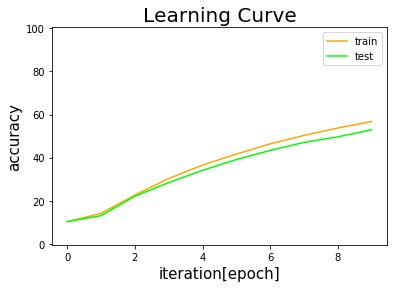

In [82]:
model = DNN(iteration=100,
                       optimizer='adam',
                       batch_mode='mini',
                       hidden_layer_list = [100, 100, 100, 100, 100, 100],
                       batch_norm=True, 
                       dropout_ratio=0.0,
                       init='he',
                       lr=0.007
           )

model.plot_learning_curve(X,y, 'acc', params)

### Dropout層の効果

dropout層あり（dropout_ratio=0.5）となしで比較すると、
ありの場合は早期に訓練データでのスコアが１００に近くなってしまい、検証データとの差が開いたままです。
なしの場合は訓練データと検証データとの差が少ないことが見て取れます。

dropout層を入れることで過学習を抑える効果があることが分かりました。

### Dropout層あり

data: 8000 batch : 800
last train accuracy is 100.0
last test accuracy is 95.7


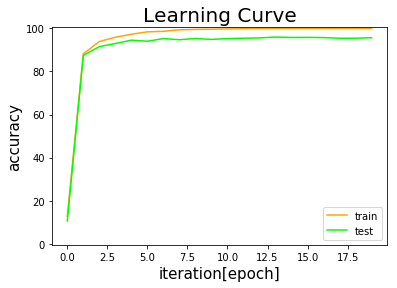

In [44]:
model = DNN(iteration=200,
                       optimizer='adam',
                       batch_mode='mini',
                       hidden_layer_list = [100, 100, 100, 100, 100, 100],
                       batch_norm=True, 
                       dropout_ratio=0.0,
                       init='he',
                       lr=0.007
           )

model.plot_learning_curve(X,y, 'acc', params)

### Dropout層なし

data: 8000 batch : 800
last train accuracy is 90.19
last test accuracy is 87.95


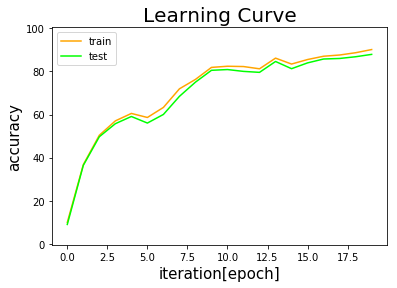

In [43]:
model = DNN(iteration=200,
                       optimizer='adam',
                       hidden_layer_list = [100, 100, 100, 100, 100, 100],
                       batch_norm=True, 
                       dropout_ratio=0.5
           )

params = {'optimizer': 'adam',
         'batch_mode' : 'mini',
         'init': 'he',
         'lr': 0.007}

model.plot_learning_curve(X,y, 'acc', params)

### BatchNormalization層

BatchNormalization層の効果を確認するために、隠れ層の総数を多めにとって試した。

ありとなしで比較するとありの方が学習速度が早いことが分かる。

### BatchNormalization層あり

data: 8000 batch : 800
last train accuracy is 17.14
last test accuracy is 18.8


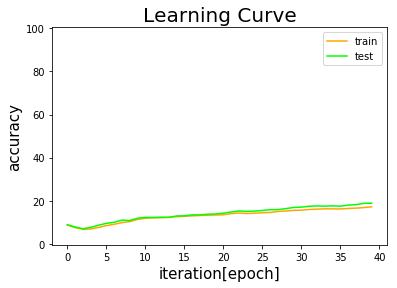

In [80]:
model = DNN(iteration=400,
                       optimizer='sgd',
                       hidden_layer_list =  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
                       batch_norm=False, 
                       dropout_ratio=0.0
           )

params = {'optimizer': 'sgd',
         'batch_mode' : 'mini',
         'init': 'he',
         'lr': 0.007}

model.plot_learning_curve(X,y, 'acc', params)

### BatchNormalization層なし

data: 8000 batch : 800
last train accuracy is 48.98
last test accuracy is 45.7


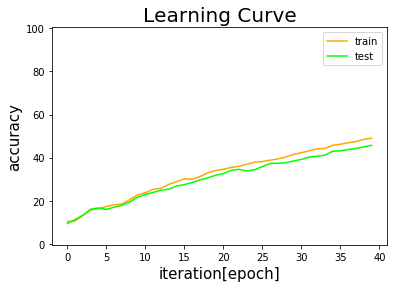

In [79]:
model = DNN(iteration=400,
                       optimizer='sgd',
                       hidden_layer_list = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
                       batch_norm=True,
                       dropout_ratio=0.0
           )

params = {'optimizer': 'sgd',
         'batch_mode' : 'mini',
         'init': 'he',
         'lr': 0.007}

model.plot_learning_curve(X,y, 'acc', params)

### 層を深くする

隠れ層の層数はhidden_layer_listで変更できるように実装した。

層を３，４，５と増やした結果を描画している。

今回は層を深くしたからと言って顕著な伸びは見られなかったが、

より多クラスな分類をするときやより精度を出したい場合は有効だと思われる。

### ３層

data: 8000 batch : 800
last train accuracy is 99.91
last test accuracy is 93.25


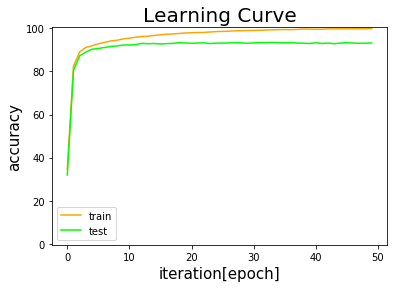

In [70]:
model = DNN(iteration=500,
                       optimizer='adam',
                       batch_mode='mini',
                       hidden_layer_list = [32],
                       batch_norm=True, 
                       dropout_ratio=0.0,
                       init='he',
                       lr=0.02
           )

model.plot_learning_curve(X,y, 'acc', params)

### 4層

data: 8000 batch : 800
last train accuracy is 100.0
last test accuracy is 93.9


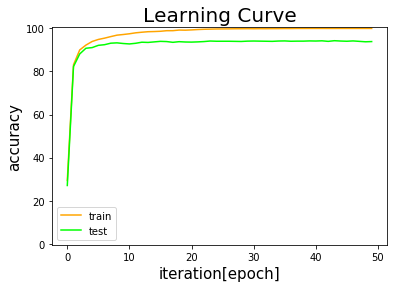

In [71]:
model = DNN(iteration=500,
                       optimizer='adam',
                       batch_mode='mini',
                       hidden_layer_list = [32, 32],
                       batch_norm=True, 
                       dropout_ratio=0.0,
                       init='he',
                       lr=0.02
           )

model.plot_learning_curve(X,y, 'acc', params)

### 5層

data: 8000 batch : 800
last train accuracy is 100.0
last test accuracy is 95.15


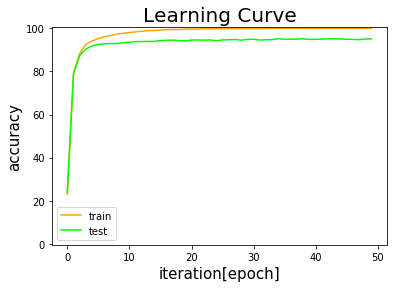

In [72]:
model = DNN(iteration=500,
                       optimizer='adam',
                       batch_mode='mini',
                       hidden_layer_list = [32, 32, 32],
                       batch_norm=True, 
                       dropout_ratio=0.0,
                       init='he',
                       lr=0.02
           )

model.plot_learning_curve(X,y, 'acc', params)

### 提出用ファイル作成

In [21]:
# test_df = pd.read_csv("test.csv")

# X_sub = test_df
# X_sub = np.array(X_sub)

# Y_pred = model.predict(X_sub)

# submission = pd.DataFrame({
#        "ImageId": np.array(test_df.index) + 1,
#        "Label": Y_pred
#    })

# submission.to_csv("./submission_001.csv", index=False)